# Jypyter (Python3) script to train 3-DOF neural network
This jupyter notebook provides an example workflow for training a neural 
network to predict forces on a spherical particle in an optical trap.
This notebook requires the training data `input.mat` and produces two
files: a trained network `nn3dof.h5` and information about the
training run `results.pkl`.
When run, this notebook also displays graphs showing how the error changes
with training epoch.

## Load the data
The training data was generated using the [optical tweezers toolbox](https://github.com/ilent2/ott).
The data is saved in a `.mat` file, so we use the `scipy.io.loadmat` function to load the data.
The file contains $1000000$ data points, each with $3$ position and $3$ force values.
We scale the position and force data to be around unity, the position values in the
data file are on the scale of microns so we multiply by $10^6$.
The force values are in units of $1/c$, which is already near unity for the particular beam power.

In [1]:
from scipy.io import loadmat
import numpy as np
from scipy.constants import c

positions = np.transpose(loadmat('input.mat')['positions']) * 1e+6 # positions [um]
forces = np.transpose(loadmat('input.mat')['forces']) # forces [N * c]

## Split validation and training data and shuffle
We randomly split the data into validation and training data.
We use 10% of the data set for validation and reserve the rest for training.

In [2]:
number_train_samples = 900000
number_val_samples = 100000

feature_number = 3
tmp = np.concatenate((positions, forces), axis=1)
np.random.shuffle(tmp)

train_data = tmp[:number_train_samples, :feature_number]
train_targets = tmp[:number_train_samples, feature_number:]

val_data = tmp[number_train_samples:number_train_samples + number_val_samples, :feature_number]
val_targets = tmp[number_train_samples:number_train_samples + number_val_samples, feature_number:]

## Setup keras model
For this problem, we use a dense neural network with 3 internal layers, 1 layer for inputs and 1 layer for outputs.
We use different numbers of nodes on the internal layers, the effect of changing the number of nodes is shown
in figure 1 in the paper: error improves at a cost of increased network size.
For training, we use the [Adam](https://keras.io/optimizers/#adam)
optimiser and we use mean squared error for the loss function.
We store mean average error and mean average percentage error for plotting.

In [3]:
from keras import models
from keras import layers

sz = 256;

model = models.Sequential()
model.add(layers.Dense(sz, activation='relu', input_shape=(train_data.shape[1],)))
model.add(layers.Dense(sz, activation='relu'))
model.add(layers.Dense(sz, activation='relu'))
model.add(layers.Dense(3))

model.compile(optimizer='adam', loss='mse', metrics=['mae', 'mape'])

model.summary()

Using TensorFlow backend.


Instructions for updating:
Colocations handled automatically by placer.
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 256)               1024      
_________________________________________________________________
dense_2 (Dense)              (None, 256)               65792     
_________________________________________________________________
dense_3 (Dense)              (None, 256)               65792     
_________________________________________________________________
dense_4 (Dense)              (None, 3)                 771       
Total params: 133,379
Trainable params: 133,379
Non-trainable params: 0
_________________________________________________________________


## Train the model
We train the model using batches of increasing size.
The batch size determines how many trial points are evaluated before updating the
network weights.
For each batch size, we pass over the entire data set `num_epochs` times, storing the
error after each epoch.  For reasonable accuracy, the number of epochs should be about 100
and we should start with small batches, however this can take a while so we have use a
reduced number of batches in this example.

In [5]:
mae = []
mape = []
val_mae = []
val_mape = []

# Realistic number of batches/epochs (takes a while)
# batches = [32, 128, 1024, 4096, 16384]
#num_epochs = 100;

# Small number of batches/epochs for the example
batches = [4096, 16384]
num_epochs = 3;

for epochs, batch_size in zip([num_epochs]*len(batches), batches):
    print(">>> ")
    print(">>> ", batch_size, " <<<")
    print(">>> ")

    history = model.fit(train_data,
                        train_targets,
                        epochs=epochs,
                        batch_size=batch_size,
                        shuffle=True,
                        validation_data=(val_data, val_targets))

    mae.extend(history.history['mean_absolute_error'])
    mape.extend(history.history['mean_absolute_percentage_error'])
    val_mae.extend(history.history['val_mean_absolute_error'])
    val_mape.extend(history.history['val_mean_absolute_percentage_error'])

>>> 
>>>  4096  <<<
>>> 
Train on 900000 samples, validate on 100000 samples
Epoch 1/3
900000/900000 [==============================] - 8s 9us/step - loss: 1.9955e-05 - mean_absolute_error: 0.0026 - mean_absolute_percentage_error: 113857.2855 - val_loss: 1.5708e-05 - val_mean_absolute_error: 0.0024 - val_mean_absolute_percentage_error: 104343.0301
Epoch 2/3
900000/900000 [==============================] - 8s 9us/step - loss: 1.3619e-05 - mean_absolute_error: 0.0023 - mean_absolute_percentage_error: 98480.8455 - val_loss: 1.1861e-05 - val_mean_absolute_error: 0.0022 - val_mean_absolute_percentage_error: 97935.9203
Epoch 3/3
900000/900000 [==============================] - 8s 9us/step - loss: 1.5180e-05 - mean_absolute_error: 0.0026 - mean_absolute_percentage_error: 146446.0980 - val_loss: 1.0419e-05 - val_mean_absolute_error: 0.0021 - val_mean_absolute_percentage_error: 112472.8664
>>> 
>>>  16384  <<<
>>> 
Train on 900000 samples, validate on 100000 samples
Epoch 1/3
900000/900000 [===

## Look at the error

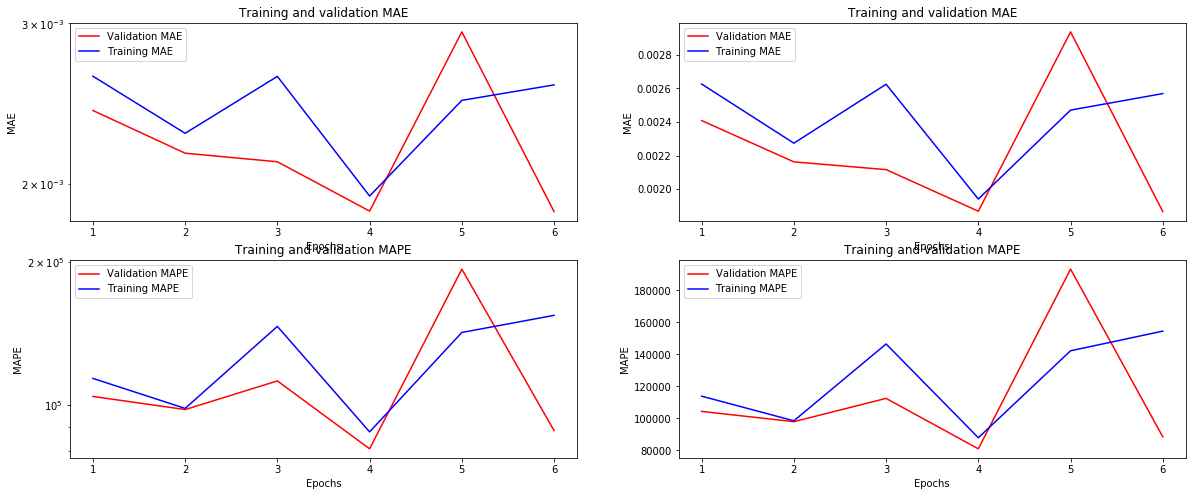

In [7]:
import matplotlib.pyplot as plt

def smooth_curve(points, factor=0.9, offset=200):
    
    # Doesn't work on small batch/epochs
    if len(points) < offset:
        return points
    
    smoothed_points = []
    for point in points:
        if len(smoothed_points) < offset:
            smoothed_points.append(points[offset])
        else:
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor + point * (1 - factor))    
    return smoothed_points

def generate_plots(mae, mape, val_mae, val_mape):
    epochs = range(1, len(mae) + 1)

    plt.figure(figsize=(20, 8))

    plt.subplot(2, 2, 1)
    plt.semilogy(epochs, val_mae, 'r', label='Validation MAE')
    plt.semilogy(epochs, mae, 'b', label='Training MAE')
    plt.title('Training and validation MAE')
    plt.xlabel('Epochs')
    plt.ylabel('MAE')
    plt.legend()

    plt.subplot(2, 2, 2)
    plt.plot(epochs, smooth_curve(val_mae), 'r', label='Validation MAE')
    plt.plot(epochs, smooth_curve(mae), 'b', label='Training MAE')
    plt.title('Training and validation MAE')
    plt.xlabel('Epochs')
    plt.ylabel('MAE')
    plt.legend()

    plt.subplot(2, 2, 3)
    plt.semilogy(epochs, val_mape, 'r', label='Validation MAPE')
    plt.semilogy(epochs, mape, 'b', label='Training MAPE')
    plt.title('Training and validation MAPE')
    plt.xlabel('Epochs')
    plt.ylabel('MAPE')
    plt.legend()

    plt.subplot(2, 2, 4)
    plt.plot(epochs, smooth_curve(val_mape), 'r', label='Validation MAPE')
    plt.plot(epochs, smooth_curve(mape), 'b', label='Training MAPE')
    plt.title('Training and validation MAPE')
    plt.xlabel('Epochs')
    plt.ylabel('MAPE')
    plt.legend()

    plt.show()
    
generate_plots(mae, mape, val_mae, val_mape)

## Look at the predicted forces
Here we look at the validation data set and compare to the true data set,
the validation data set is used for training the model so a better estimate
of the error would use an additional data set that hasn't previously been seen by the model.

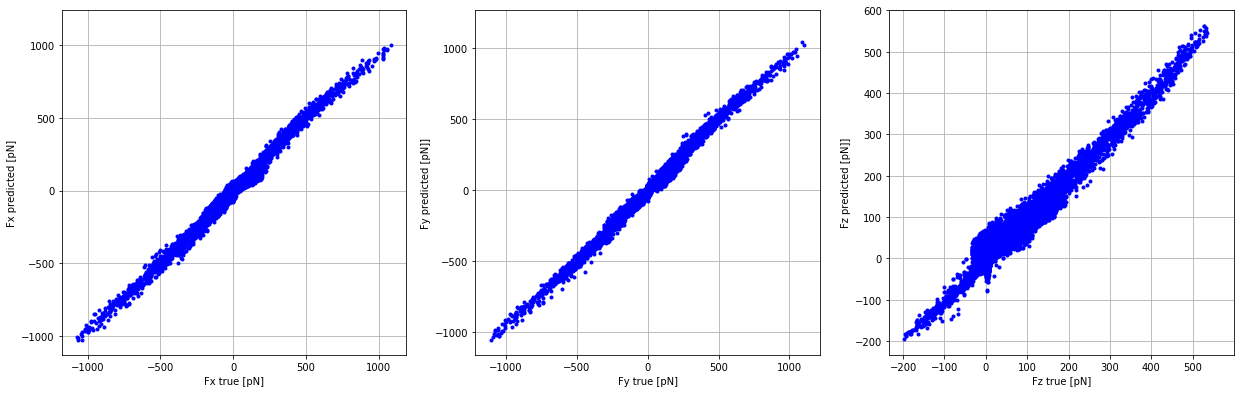

In [9]:
predictions = model.predict(val_data)

plt.figure(figsize=(21, 7))

plt.subplot(1, 3, 1)
plt.plot(val_targets[:, 0] / c * 1e+12, 
         predictions[:, 0] / c * 1e+12, 
         'b.')
plt.xlabel('Fx true [pN]')
plt.ylabel('Fx predicted [pN]')
plt.axis('equal')
plt.axis('square')
plt.grid(True)

plt.subplot(1, 3, 2)
plt.plot(val_targets[:, 1] / c * 1e+12, 
         predictions[:, 1] / c * 1e+12,
         'b.')
plt.xlabel('Fy true [pN]')
plt.ylabel('Fy predicted [pN]]')
plt.axis('equal')
plt.axis('square')
plt.grid(True)

plt.subplot(1, 3, 3)
plt.plot(val_targets[:, 2] / c * 1e+12, 
         predictions[:, 2] / c * 1e+12, 
         'b.')
plt.xlabel('Fz true [pN]')
plt.ylabel('Fz predicted [pN]]')
plt.axis('equal')
plt.axis('square')
plt.grid(True)

## Save the result
The output files can be loaded back into python or Matlab for later use.

In [11]:
save_file_name = "nn3dof.h5"
model.save(save_file_name)

import pickle

save_file_name_pkl = "results.pkl"
with open(save_file_name_pkl, 'wb') as f:
    pickle.dump([mae, mape, val_mae, val_mape], f)